double     | Ep    1 | R  -50 | ε=0.846
double     | Ep  100 | R  -35 | ε=0.050
double     | Ep  200 | R    6 | ε=0.050
double     | Ep  300 | R   10 | ε=0.050
double     | Ep  400 | R    8 | ε=0.050
double     | Ep  500 | R    6 | ε=0.050
double     | Ep  600 | R    8 | ε=0.050
double     | Ep  700 | R    7 | ε=0.050
double     | Ep  800 | R    7 | ε=0.050
Training finished – saved curves_double.png


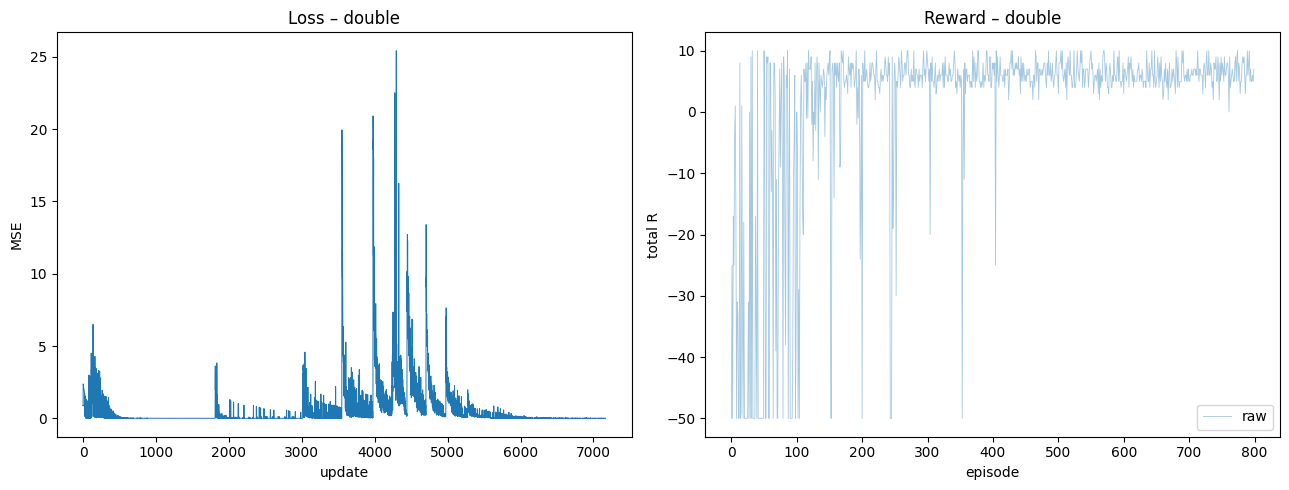

In [12]:
from __future__ import annotations

import argparse, math, random
from collections import deque
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ---------------------------------------------------------------------------
# Environment wrapper (player‑mode Gridworld)
# ---------------------------------------------------------------------------
from sample_data.Gridworld import Gridworld  # noqa: E402

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- helpers to encode board ------------------------------------------------

def onehot_state(board, size=4):
    lay = np.zeros((4, size, size), dtype=np.float32)
    mp = {"Player": 0, "Goal": 1, "Pit": 2, "Wall": 3}
    for n, p in board.components.items():
        lay[mp[n], p.pos[0], p.pos[1]] = 1.0
    return lay.flatten()

class GridEnvWrapper:
    ACTIONS = {0: "u", 1: "d", 2: "l", 3: "r"}
    def __init__(self, size=4):
        self.raw = Gridworld(size=size, mode="player")
        self.size = size
    def reset(self):
        self.raw.initGridPlayer()
        return onehot_state(self.raw.board, self.size)
    def step(self, idx: int):
        self.raw.makeMove(self.ACTIONS[idx])
        r = self.raw.reward(); done = r in {10, -10}
        return onehot_state(self.raw.board, self.size), float(r), done

# ---------------------------------------------------------------------------
# Replay Buffer --------------------------------------------------------------
class ReplayBuffer:
    def __init__(self, cap: int):
        self.buf: deque = deque(maxlen=cap)
    def push(self, s, a, r, s2, d):
        self.buf.append((s, a, r, s2, d))
    def sample(self, b):
        s, a, r, s2, d = map(np.array, zip(*random.sample(self.buf, b)))
        return (
            torch.tensor(s, dtype=torch.float32, device=device),
            torch.tensor(a, dtype=torch.int64,  device=device).unsqueeze(1),
            torch.tensor(r, dtype=torch.float32, device=device).unsqueeze(1),
            torch.tensor(s2, dtype=torch.float32, device=device),
            torch.tensor(d, dtype=torch.float32, device=device).unsqueeze(1),
        )
    def __len__(self):
        return len(self.buf)

# ---------------------------------------------------------------------------
# Network definitions --------------------------------------------------------
class DQN(nn.Module):
    def __init__(self, inp, hid, n_act):
        super().__init__(); self.net = nn.Sequential(nn.Linear(inp, hid), nn.ReLU(), nn.Linear(hid, n_act))
    def forward(self, x): return self.net(x)

class DuelingDQN(nn.Module):
    def __init__(self, inp, hid, n_act):
        super().__init__()
        self.feat = nn.Sequential(nn.Linear(inp, hid), nn.ReLU())
        self.val  = nn.Sequential(nn.Linear(hid, hid), nn.ReLU(), nn.Linear(hid, 1))
        self.adv  = nn.Sequential(nn.Linear(hid, hid), nn.ReLU(), nn.Linear(hid, n_act))
    def forward(self, x):
        x = self.feat(x); v = self.val(x); a = self.adv(x)
        return v + a - a.mean(1, keepdim=True)

# ---------------------------------------------------------------------------
# RL helper functions --------------------------------------------------------

def eps_greedy(s, net, n_act, step, e0, e1, decay):
    eps = e1 + (e0 - e1) * math.exp(-step / decay)
    if random.random() < eps:
        return random.randrange(n_act)
    with torch.no_grad():
        return int(net(torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)).argmax())


def optimize(pol, tgt, buf, opt, batch, gamma, double):
    if len(buf) < batch: return None
    s, a, r, s2, d = buf.sample(batch)
    q = pol(s).gather(1, a)
    with torch.no_grad():
        if double:
            best = pol(s2).argmax(1, keepdim=True)
            q_next = tgt(s2).gather(1, best)
        else:
            q_next = tgt(s2).max(1)[0].unsqueeze(1)
        tgt_val = r + gamma * q_next * (1 - d)
    loss = nn.functional.mse_loss(q, tgt_val)
    opt.zero_grad(); loss.backward(); opt.step(); return loss.item()

# ---------------------------------------------------------------------------
# Training -------------------------------------------------------------------

def moving_avg(seq: List[float], k: int) -> List[float]:
    if k <= 1: return seq
    cumsum = np.cumsum(np.insert(seq, 0, 0))
    ma = (cumsum[k:] - cumsum[:-k]) / k
    pad = [None]*(k-1)  # keep length consistent
    return pad + ma.tolist()


def train(cfg):
    env = GridEnvWrapper(); state_dim = env.reset().shape[0]; n_act = 4

    dueling = cfg.algo in {"dueling", "dueldouble"}; double = cfg.algo in {"double", "dueldouble"}
    Net = DuelingDQN if dueling else DQN
    online, target = Net(state_dim, 128, n_act).to(device), Net(state_dim, 128, n_act).to(device)
    target.load_state_dict(online.state_dict())

    opt = optim.Adam(online.parameters(), lr=cfg.lr)
    buf = ReplayBuffer(cfg.buffer_capacity)

    rewards: List[float] = []
    losses:  List[float] = []
    step = 0

    for ep in range(1, cfg.num_episodes+1):
        s = env.reset(); ep_r = 0
        for _ in range(cfg.max_steps):
            a = eps_greedy(s, online, n_act, step, cfg.eps_start, cfg.eps_end, cfg.eps_decay)
            step += 1
            s2, r, done = env.step(a)
            buf.push(s, a, r, s2, done)
            s = s2; ep_r += r
            l = optimize(online, target, buf, opt, cfg.batch_size, cfg.gamma, double)
            if l is not None: losses.append(l)
            if done: break
        rewards.append(ep_r)
        if ep % cfg.target_update_interval == 0:
            target.load_state_dict(online.state_dict())
        if ep % 100 == 0 or ep == 1:
            eps_now = max(cfg.eps_end, cfg.eps_start*math.exp(-step/cfg.eps_decay))
            print(f"{cfg.algo:<10} | Ep {ep:4d} | R {ep_r:4.0f} | ε={eps_now:.3f}")

    # ---- plot ----
    ma = moving_avg(rewards, cfg.smooth)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
    ax1.plot(losses, lw=0.7); ax1.set_title(f"Loss – {cfg.algo}"); ax1.set_xlabel("update"); ax1.set_ylabel("MSE")
    ax2.plot(rewards, label="raw", alpha=0.4, lw=0.6)
    if cfg.smooth > 1:
        ax2.plot(ma, label=f"MA({cfg.smooth})", lw=1.2)
    ax2.set_title(f"Reward – {cfg.algo}"); ax2.set_xlabel("episode"); ax2.set_ylabel("total R"); ax2.legend()
    plt.tight_layout(); fname = f"curves_{cfg.algo}.png"; fig.savefig(fname)
    print("Training finished – saved", fname)

# ---------------------------------------------------------------------------
# CLI ------------------------------------------------------------------------

def args():
    p = argparse.ArgumentParser(description="DQN variants on player‑mode Gridworld")
    p.add_argument("--algo", choices=["naive","double","dueling","dueldouble"], default="double")
    p.add_argument("--num_episodes", type=int, default=800)
    p.add_argument("--max_steps", type=int, default=50)
    p.add_argument("--batch_size", type=int, default=64)
    p.add_argument("--gamma", type=float, default=0.99)
    p.add_argument("--buffer_capacity", type=int, default=10000)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--target_update_interval", type=int, default=50)
    p.add_argument("--eps_start", type=float, default=1.0)
    p.add_argument("--eps_end", type=float, default=0.05)
    p.add_argument("--eps_decay", type=float, default=300)
    p.add_argument("--smooth", type=int, default=1, help="moving‑average window for reward curve")
    a, _ = p.parse_known_args(); return a

if __name__ == "__main__":
    train(args())
